In [2]:
!pip install numpy opencv-python scikit-learn

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
    --------------------------------------- 0.5/39.5 MB 985.5 kB/s eta 0:00:40
    --------------------------------------- 0.5/39.5 MB 985.5 kB/s eta 0:00:40
    --------------------------------------- 0.8/39.5 MB 987.4 kB/s eta 0:00:40
   - -------------------------------------- 1.0/39.5 MB 1.0 MB/s eta 0:00:37
   - -------------------------------------- 1.3/39.5 MB 1.0 MB/s eta 0:00:37
   - -------------------------------------- 1.6/39.5 MB 1.1 MB/s eta 0:00:35
   - -------------------------------------- 1.8/39.5 MB 1.1 MB/s eta 0:00:34
   -- ------------------------------------- 2.1/39.5 MB 1.2 MB/s eta 0:00:33
   -- ------------------------------------- 2.4/39.5 MB 1.2 MB/s eta 0:00:32
   -- ---------------

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from skimage.feature import hog
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

In [7]:
def load_images_from_directory(directory, image_size=(150, 150)):
    images = []
    labels = []
    label_mapping = {'NORMAL': 0, 'PNEUMONIA': 1, 'COVID': 2, 'COVID19': 2}  # تأكد من تضمين جميع الأسماء الممكنة
    for label in os.listdir(directory):
        if label not in label_mapping:
            print(f"Skipping unknown category: {label}")
            continue
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                img = Image.open(img_path).resize(image_size)
                img = img.convert('RGB')
                images.append(np.array(img))
                labels.append(label_mapping[label])
    return np.array(images), np.array(labels)

In [10]:
# Set paths for training and testing datasets
train_dir = r'C:\Users\MSI\Downloads\archive\Data\train'
test_dir = r'C:\Users\MSI\Downloads\archive\Data\test'

# Load datasets
train_images, train_labels = load_images_from_directory(train_dir)
test_images, test_labels = load_images_from_directory(test_dir)

In [11]:
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")

Train images shape: (5144, 150, 150, 3)
Test images shape: (1288, 150, 150, 3)


In [12]:
# Function to extract HOG features
def extract_hog_features(images):
    hog_features = []
    for img in images:
        img_gray = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
        fd, _ = hog(img_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        hog_features.append(fd)
    return np.array(hog_features)

In [13]:
# Extract HOG features
train_hog_features = extract_hog_features(train_images)
test_hog_features = extract_hog_features(test_images)

In [14]:
# Split training data
X_train, X_val, y_train, y_val = train_test_split(train_hog_features, train_labels, test_size=0.2, random_state=42)

In [15]:
# Train SVM with GridSearchCV
svm_clf = SVC(kernel='linear', probability=True)
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
grid_search = GridSearchCV(svm_clf, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=SVC(kernel='linear', probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

In [16]:
# Get best model
svm_clf_best = grid_search.best_estimator_
joblib.dump(svm_clf_best, 'pneumonia_detection_model.pkl')
print("Model saved to 'pneumonia_detection_model.pkl'")

Model saved to 'pneumonia_detection_model.pkl'


In [17]:
# Validate model
val_predictions = svm_clf_best.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")

Validation accuracy: 95.14%


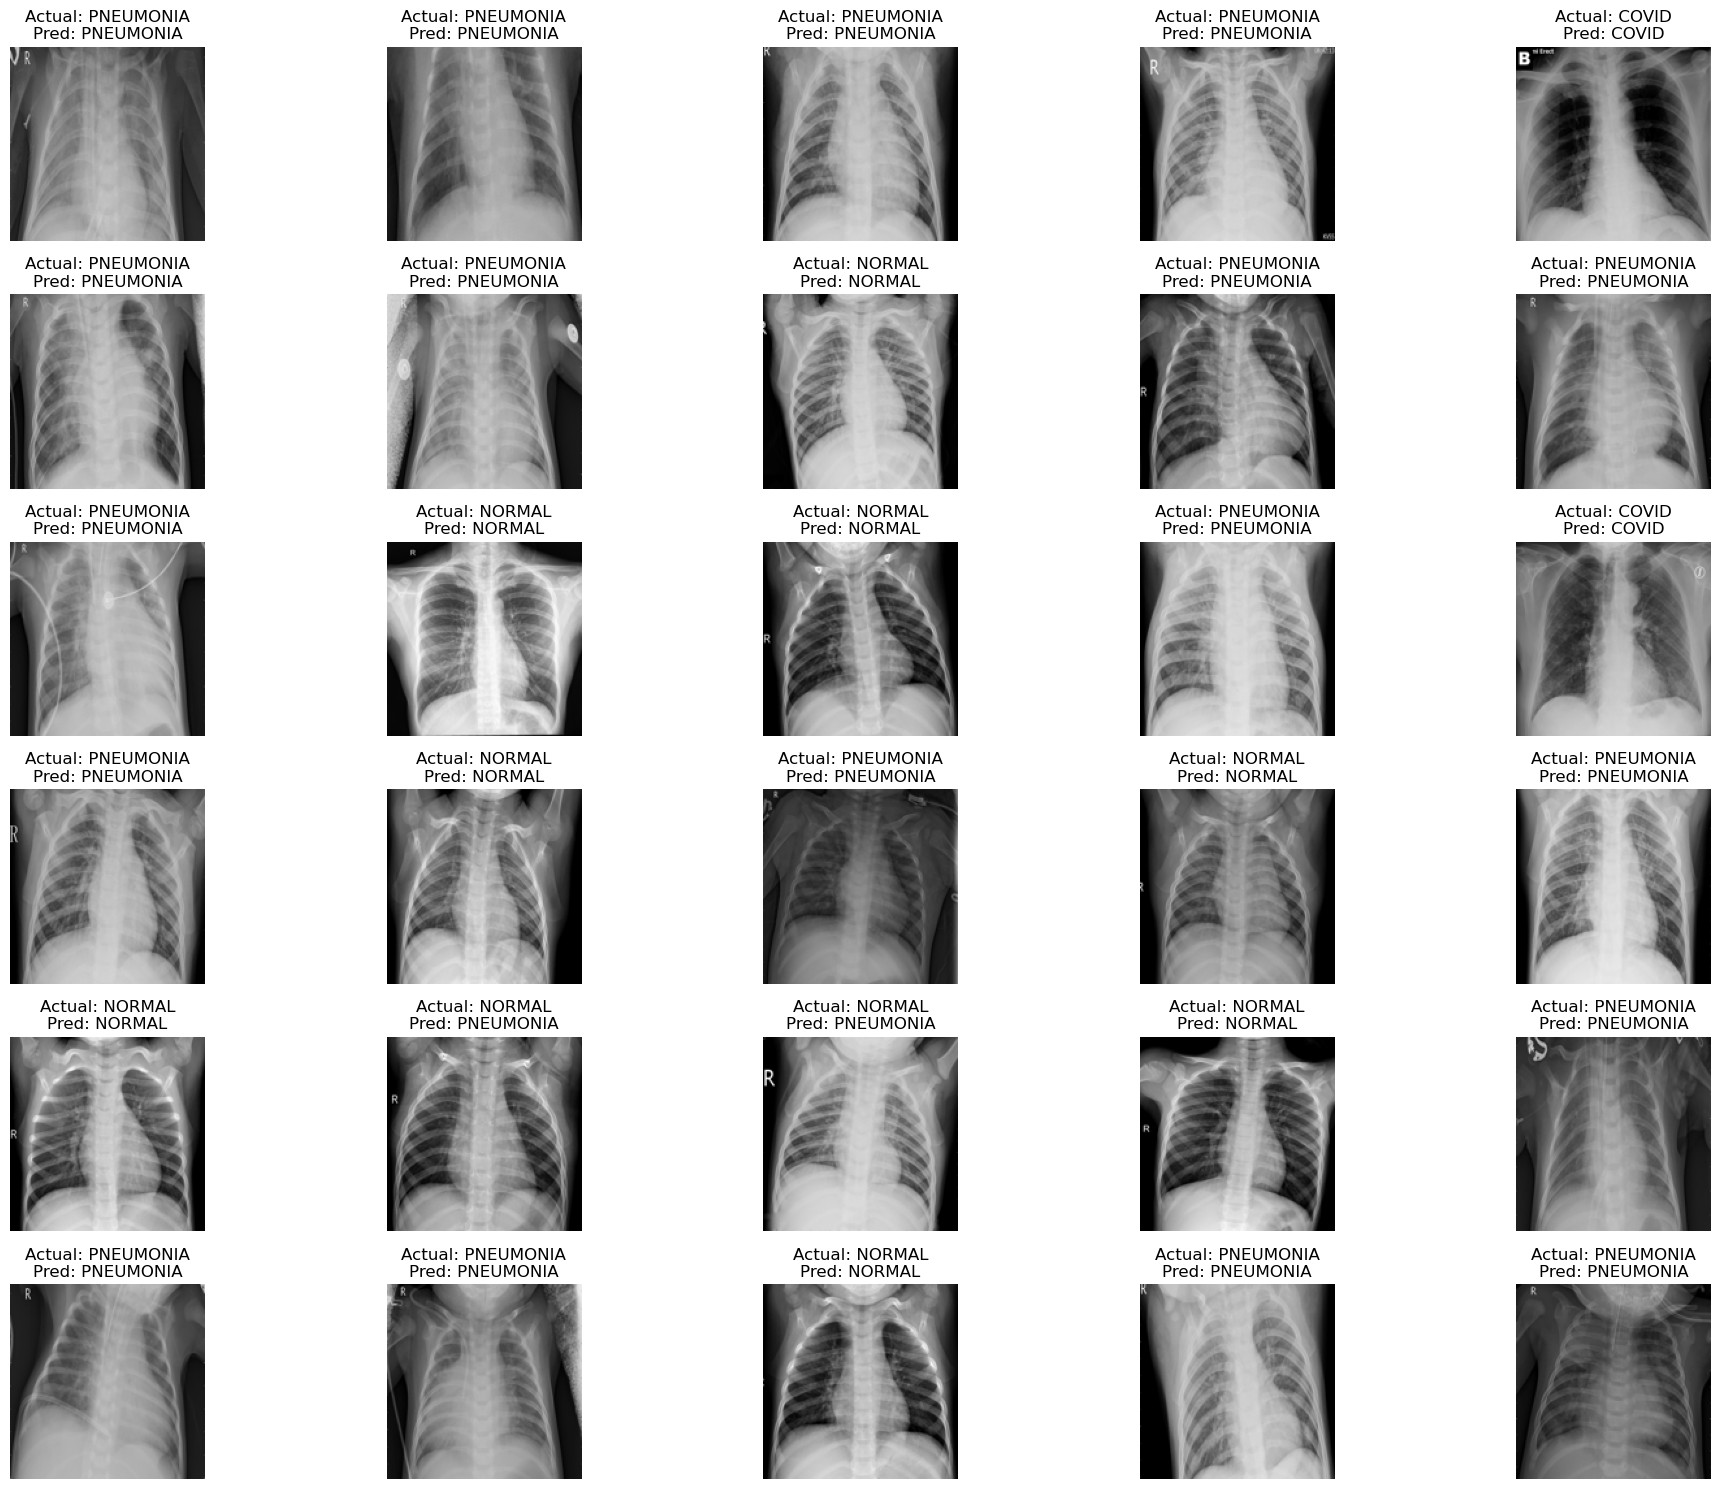

In [23]:
def test_with_random_images(test_images, test_labels, test_hog_features, model, num_images=30):
    selected_idx = np.random.choice(len(test_images), num_images, replace=False)
    selected_images = test_images[selected_idx]
    selected_labels = test_labels[selected_idx]
    selected_features = test_hog_features[selected_idx]
    predictions = model.predict(selected_features)
    
    class_names = ['NORMAL', 'PNEUMONIA', 'COVID']
    fig, axes = plt.subplots(6, 5, figsize=(20, 15))
    axes = axes.ravel()
    
    for i in range(num_images):
        img = selected_images[i]
        label = selected_labels[i]
        predicted = predictions[i]
        ax = axes[i]
        ax.imshow(img)
        ax.set_title(f"Actual: {class_names[label]}\nPred: {class_names[predicted]}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run test with 30 random images
test_with_random_images(test_images, test_labels, test_hog_features, svm_clf_best, num_images=30)

In [25]:
# Confusion matrix and classification report
cm = confusion_matrix(test_labels, svm_clf_best.predict(test_hog_features))
print(f"Confusion Matrix:\n{cm}")
print("Classification Report:")
print(classification_report(test_labels, svm_clf_best.predict(test_hog_features)))

Confusion Matrix:
[[302  15   0]
 [ 23 832   0]
 [  1   4 111]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       317
           1       0.98      0.97      0.98       855
           2       1.00      0.96      0.98       116

    accuracy                           0.97      1288
   macro avg       0.97      0.96      0.96      1288
weighted avg       0.97      0.97      0.97      1288



In [27]:
import seaborn as sns

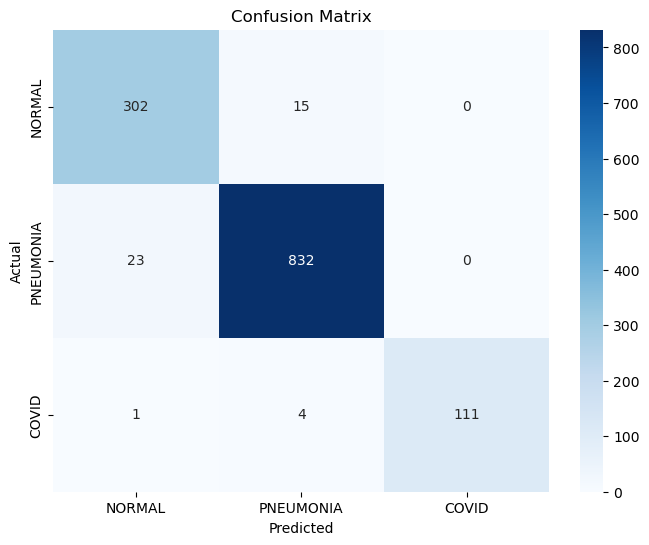

In [28]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA', 'COVID'], yticklabels=['NORMAL', 'PNEUMONIA', 'COVID'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [29]:
# Specify the path to save the model
save_path = r'C:\Users\MSI\Downloads\best_svm_model.pkl'
joblib.dump(svm_clf_best, save_path)
print(f"Best model saved as '{save_path}'")

Best model saved as 'C:\Users\MSI\Downloads\best_svm_model.pkl'
